In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, recall_score, make_scorer, roc_auc_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from light_famd import FAMD
import prince
import gower

In [2]:
DATA_PATH = './archive'

df = pd.read_csv(os.path.join(DATA_PATH, 'Base.csv'))

# intended_balcon_amount is the only variable where missingness is represented by any negative value
# Replace all negative intended_balcon_amount values with -1
df.loc[df['intended_balcon_amount'] < 0, 'intended_balcon_amount'] = -1

# List of columns where missingness is indicated with -1
cols_missing_neg1 = ['prev_address_months_count',
                     'current_address_months_count',
                     'bank_months_count',
                     'session_length_in_minutes',
                     'device_distinct_emails_8w',
                     'intended_balcon_amount'] # already replaced all negative values with -1

# Add missingness indicator variables to cols_missing_neg1
for col in cols_missing_neg1:
    df[col + '_ismissing'] = (df[col] == -1).astype(int)

#remove columns with large amounts of missing data and columns that are always 0
df = df.drop(['bank_months_count',
              'prev_address_months_count',
              'intended_balcon_amount',
              'device_fraud_count'], # always 0
              axis = 1)

In [3]:
target = 'fraud_bool'
X = df.drop(target,axis=1)
y = df[target]

In [4]:
thresh = 25
num_feats = X.select_dtypes(include='number').columns.tolist()
non_num_feats = X.select_dtypes(exclude='number').columns.tolist()
cont_feats = [feat for feat in num_feats if df[feat].nunique() >= thresh]
disc_feats = [feat for feat in num_feats if df[feat].nunique() < thresh]

In [5]:
len(disc_feats), len(cont_feats), len(non_num_feats)

(17, 11, 5)

In [6]:
len(disc_feats) + len(cont_feats) + len(non_num_feats)

33

In [7]:
len(X.columns.tolist())

33

In [8]:
X['payment_type'].nunique()

5

In [9]:
# Do the OHE first
# Dealing with disc_feats
bin_vars = list()
for col in disc_feats:
    n_uniq = X[col].nunique()
    if n_uniq == 2: bin_vars.append(col)
        
non_num_feats_ext = non_num_feats + bin_vars
assert len(non_num_feats_ext) == len(bin_vars) + len(non_num_feats)

# For these remaining variables, makes more sense to treat them as cts
rem_vars = [col for col in disc_feats if col not in bin_vars]
cont_feats_ext = cont_feats + rem_vars
assert len(cont_feats_ext) == len(cont_feats) + len(rem_vars)

# Dealing with non_num_feats
X_tr_non_num_feats = list()
for col in non_num_feats_ext:
    n_uniq = X[col].nunique()
    if n_uniq <= 2: 
        X_tr_non_num_feats.append(
            pd.get_dummies(X[col],prefix=f"{col}_", drop_first=True)
        )
    else:
        X_tr_non_num_feats.append(
            pd.get_dummies(X[col],prefix=f"{col}_",drop_first=False)
        )
X_tr_non_num_feats = pd.concat(X_tr_non_num_feats,axis=1)

# Without transformation, with OHE
X = pd.concat([X[cont_feats_ext], X_tr_non_num_feats], axis=1)

In [10]:
# Perform scaling to (0,1)
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(X[cont_feats_ext])
numerical_data = scaler.transform(X[cont_feats_ext])
numerical_data = pd.DataFrame(numerical_data,index=X.index,columns=cont_feats_ext)

X_trans = pd.concat([numerical_data, X_tr_non_num_feats], axis=1)

In [11]:
X_trans_first_mnth = X_trans[X_trans['month'] == 0.0]
X_trans_first_mnth = X_trans_first_mnth.drop('month',axis=1, inplace=False)
len(numerical_data.columns) #index 15 and on is categorical

16

In [12]:
X_trans_first_mnth.to_numpy().shape

(132440, 52)

In [68]:
# Trying Kmodes 
# See docs in https://github.com/nicodv/kmodes

from kmodes.kmodes import KModes
data = X_trans_first_mnth.to_numpy()
km = KModes(n_clusters=2, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(data, categorical=list(range(15,53)))

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 25816, cost: 2412797.0
Run 1, iteration: 2/100, moves: 3306, cost: 2412797.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 19948, cost: 2405318.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 26379, cost: 2416537.0
Run 3, iteration: 2/100, moves: 0, cost: 2416537.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 21692, cost: 2400758.0
Run 4, iteration: 2/100, moves: 16456, cost: 2400758.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 26919, cost: 2406259.0
Run 5, iteration: 2/100, moves: 21269, cost: 2406259.0
Best run was number 4


In [61]:
y_first_mnth = y[X_trans_first_mnth.index]

In [69]:
clusters

array([0, 1, 0, ..., 1, 0, 0], dtype=uint16)

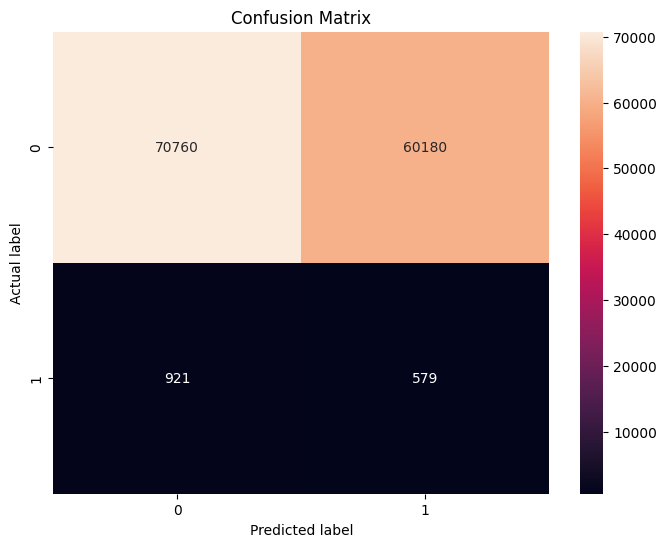

In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_first_mnth, clusters)

# Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [71]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Accuracy
accuracy = accuracy_score(y_first_mnth, clusters)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(y_first_mnth, clusters)
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_first_mnth, clusters)
print(f"Recall: {recall}")

# F1 Score
f1 = f1_score(y_first_mnth, clusters)
print(f"F1 Score: {f1}")

Accuracy: 0.5386514648142555
Precision: 0.009529452426800969
Recall: 0.386
F1 Score: 0.01859972052233412
